## CSE 482 Mini-Project Report for Crime Prediction

The goal of this project is to create a model that will be able to predict whether or not a crime that requires police attention will occur in a given location when provided with certain criteria about the area. These criteria include factors such as weather, population, and type of area. In order to do so, this model relies on the analysis of crime records to build labels on where/when urgent crimes have occured. As an attempt to build the most accurate model, multiple data sets were analyzed, including weather data and population data. After processing the data set, different machine learning models were applied in an attempt to find one that yielded the best prediction. These included classic classification strategies such as logistic and linear regression, but also attempted to explore whether or not clustering could be applied to act in a similar classification manner.

## A. Data Loading

**1.** You can download the 20-year crime data from https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

In [2]:
crime_data = pd.read_csv("crime_data.csv")

**2.** Please download the side information data (weather and population density). The weather data is accessible from NOAA Global Summary of the Day website (https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/) The population density data is accessible from Wikipedia (https://en.wikipedia.org/wiki/Community_areas_in_Chicago).

In [4]:
weather_data = pd.read_csv("weather.csv")
population_data = pd.read_csv("population.csv")

## B. Data Creation and Preprocessing


**Step 1:**
Check if there is an abudance of missing data in entries

If there is not too much missing data, remove the rows

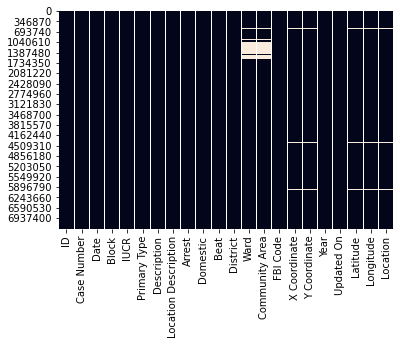

In [3]:
# Try to visualize how much data is missing from each data set
# As we are doing so, format the dates using the pandas function
sns.heatmap(crime_data.isnull(), cbar=False)
crime_data.Date = pd.to_datetime(crime_data.Date, format='%m/%d/%Y %I:%M:%S %p')
crime_data = crime_data.dropna()

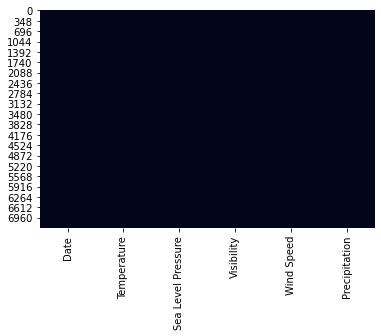

In [5]:
weather_data.Date = pd.to_datetime(weather_data.Date, format='%Y-%m-%d')
sns.heatmap(weather_data.isnull(), cbar=False)
weather_data = weather_data.dropna()

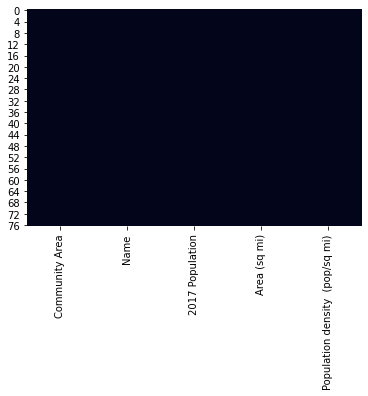

In [6]:
sns.heatmap(population_data.isnull(), cbar=False)
population_data = population_data.dropna()

**Step 2:**
Explore counts of different values to decide which data to use

In [7]:
crime_data['Primary Type'].value_counts()

THEFT                                1395636
BATTERY                              1211360
CRIMINAL DAMAGE                       754500
NARCOTICS                             660127
ASSAULT                               420951
OTHER OFFENSE                         409401
BURGLARY                              374858
MOTOR VEHICLE THEFT                   300241
DECEPTIVE PRACTICE                    272248
ROBBERY                               249619
CRIMINAL TRESPASS                     187376
WEAPONS VIOLATION                      81250
PROSTITUTION                           60894
PUBLIC PEACE VIOLATION                 47231
OFFENSE INVOLVING CHILDREN             45315
CRIM SEXUAL ASSAULT                    24430
SEX OFFENSE                            23899
INTERFERENCE WITH PUBLIC OFFICER       16980
GAMBLING                               13381
LIQUOR LAW VIOLATION                   12360
ARSON                                  10838
HOMICIDE                               10531
KIDNAPPING

In [8]:
# Number of crime counts seems to drop off after the top ~15 values
crime_types = crime_data['Primary Type'].value_counts().iloc[:15].index

In [9]:
# In order to not over fit our model and ligthen the processing load
# We can drop the types of crime that do not appear often
crime_types = crime_types.to_list()
drops = crime_data.loc[crime_data['Primary Type'].apply(lambda x: x not in crime_types), 'Primary Type'].index
crime_data.drop(drops, inplace=True)

In [10]:
# Define location by ward
crime_data['Location'] = crime_data['Ward']

In [11]:
# Create target attribute by re-defining crime into cases where 
# target cannot be caught later or results in immediate physical violence
# This is one attempt to interpret the data given in a new way

def isUrgent(row):
    '''
    Create target attribute by re-defining crime into cases where 
    target cannot be caught later or results in immediate physical violence
    1 if crime needs attention asap, 0 if catchable later
    '''
    if row['Primary Type'] in [2,5] or row['Arrest'] == False:
        return 1
    return 0

crime_data['Urgent'] = crime_data.apply(lambda x: isUrgent(x), axis=1)

In [12]:
# Drop locations not in majority
# Again, we don't have to overfit or include records that don't occur often
location_types = crime_data['Location Description'].value_counts().iloc[:15].index
location_types = location_types.to_list()
ldrops = crime_data.loc[crime_data['Location Description'].apply(lambda x: x not in location_types), 'Location Description'].index
crime_data.drop(ldrops, inplace=True)

In [13]:
# Add a column to crime DataFrame relating to which day of the week crime took place
crime_data['Day of Week'] = crime_data['Date'].dt.dayofweek

In [14]:
# Add a column to crime DataFrame relating to which month crime took place in
crime_data['Month'] = crime_data['Date'].dt.month

In [15]:
# Add a column to crime DataFrame relating to which year crime took place in
crime_data['Year'] = crime_data['Date'].dt.year

In [16]:
# Add a column to crime DataFrame relating to the time of day that the crime took place
def getTimeOfDay(hour_time, noon, night, morning):
    """
    Function to determine whether a given time is morning, afternoon, or night. 
    Function should return the value 0 if morning, 
    1 if afternoon, or 2 if night.
    """
    hour_time = hour_time.time()
    if hour_time > morning and hour_time < noon:
        return 0
    elif hour_time > noon and hour_time < night:
        return 1
    return 2

time1 = pd.to_datetime('12:00:00').time()
time2 = pd.to_datetime('19:00:00').time()
time3 = pd.to_datetime('6:00:00').time()
crime_data['Time of Day'] = crime_data['Date'].apply(lambda x: getTimeOfDay(x,time1,time2,time3))

In [17]:
# Convert the date column to remove specific time data
crime_data['Date'] = crime_data['Date'].dt.date

In [18]:
# discretize arrests
arrests = {True : 1, False: 0}
crime_data['Arrest'] = crime_data['Arrest'].apply(lambda x: arrests[x])

In [19]:
# discretize domestic
crime_data['Domestic'] = crime_data['Domestic'].apply(lambda x: arrests[x])

In [20]:
# Save a copy of the data frame for visualization
visual_data = crime_data.copy()

In [21]:
# Convert location description to number representations
descrips = {
    "STREET" : 1,
    "RESIDENCE" : 2,
    "APARTMENT" : 3,
    "SIDEWALK" : 4,
    "OTHER" : 5,
    "PARKING LOT/GARAGE(NON.RESID.)" : 6,
    "ALLEY" : 7,
    "SCHOOL, PUBLIC, BUILDING" : 8,
    "RESIDENCE-GARAGE" : 9,
    "SMALL RETAIL STORE" : 10,
    "RESIDENCE PORCH/HALLWAY" : 11,
    "RESTAURANT" : 12,
    "VEHICLE NON-COMMERCIAL" : 13,
    "GROCERY FOOD STORE" : 14,
    "DEPARTMENT STORE" : 15
}

crime_data['Location Description'] = crime_data['Location Description'].apply(lambda x: descrips[x])

In [22]:
# Convert crime types to number representations
crimes = {
    "THEFT" : 1,
    "BATTERY" : 2,
    "CRIMINAL DAMAGE" : 3,
    "NARCOTICS" : 4,
    "ASSAULT" : 5,
    "OTHER OFFENSE" : 6,
    "BURGLARY" : 7,
    "MOTOR VEHICLE THEFT" : 8,
    "DECEPTIVE PRACTICE" : 9,
    "ROBBERY" : 10,
    "CRIMINAL TRESPASS" : 11,
    "WEAPONS VIOLATION" : 12,
    "PROSTITUTION" : 13,
    "PUBLIC PEACE VIOLATION" : 14,
    "OFFENSE INVOLVING CHILDREN" : 15
}

crime_data['Primary Type'] = crime_data['Primary Type'].apply(lambda x: crimes[x])

In [23]:
def getWeather(temp, precip):
    """
    Function to determine whether a given day is clear, rainy or snowy. 
    Function should return the value 0 if clear, 1 if rainy, or 2 if snowy.
    """
    temp = float(temp)
    precip = float(precip)
    if precip == 0:
        return 0
    elif temp > 32:
        return 1
    return 2

weather_conds = []
for i,j in enumerate(weather_data['Temperature']):
    condition = getWeather(j,weather_data['Precipitation'][i])
    weather_conds.append(condition)

weather_data['Weather Condition'] = weather_conds

In [24]:
# Define weather dates in the same manner as crime records in order to join data sets
weather_data['Date'] = weather_data['Date'].dt.date

In [25]:
# Convert population data to float representations
population_data['2017 Population'] = population_data['2017 Population'].apply(lambda x: float(x.replace(',','')))
population_data['Population density  (pop/sq mi)'] = population_data['Population density  (pop/sq mi)'].apply(lambda x: float(x.replace(',','')))

In [26]:
# Merge our different sets of data into one
# Create multiple frames for different purposes: interpretation, regression, clustering, etc.
big_data = pd.merge(crime_data, weather_data, how="inner", on=["Date", "Date"])
big_visual = pd.merge(visual_data, weather_data, how="inner", on=["Date", "Date"])

In [27]:
# Continue merging data
big_data = pd.merge(big_data, population_data, how='inner', on=['Community Area', 'Community Area'])
big_visual = pd.merge(big_visual, population_data, how='inner', on=['Community Area', 'Community Area'])

In [28]:
# Drop all attributes that will not help us make a prediction
to_drop = ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Description', 'Beat', 
           'District', 'Ward', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 
           'Latitude', 'Longitude', 'Sea Level Pressure', 'Precipitation',
           'Name', 'Area (sq mi)', 'Primary Type', 'Arrest']

to_drop_vis = ['ID', 'Case Number', 'Block', 'IUCR', 'Description', 'Beat', 
           'District', 'Ward', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 
           'Latitude', 'Longitude', 'Sea Level Pressure', 'Precipitation',
           'Name', 'Area (sq mi)']

big_data = big_data.drop(to_drop, axis=1)
big_visual = big_visual.drop(to_drop_vis, axis=1)
clustering_data = big_data.drop(['Urgent'], axis = 1)

**Step 2:** Apply dimensionality reduction to data

In [29]:
# Since the goal of this data set is to be able to cluster it
# I first want to scale the attributes
scaler = MinMaxScaler()
scale_data = scaler.fit_transform(clustering_data)

Final data frames displayed:

In [32]:
#big_data.to_csv('big_data.csv', index=False)
big_data

,Location Description,Domestic,Community Area,Year,Location,Urgent,Day of Week,Month,Time of Day,Temperature,Visibility,Wind Speed,Weather Condition,2017 Population,Population density (pop/sq mi)
0,2,1,61.0,2015,12.0,1,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
1,1,0,61.0,2015,16.0,1,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
2,11,1,61.0,2015,16.0,0,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
3,3,0,61.0,2015,16.0,1,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
4,1,0,61.0,2015,3.0,1,5,9,2,76.9,9.9,6.2,0,39561.0,8190.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505657,2,0,55.0,2020,10.0,1,3,12,2,23.1,8.9,16.8,2,9418.0,1797.33
5505658,2,0,55.0,2020,10.0,1,3,12,1,23.1,8.9,16.8,2,9418.0,1797.33
5505659,1,0,55.0,2020,10.0,0,4,12,0,14.4,10.0,10.8,0,9418.0,1797.33
5505660,2,0,55.0,2020,10.0,1,0,12,1,33.2,10.0,11.2,0,9418.0,1797.33


In [33]:
#clustering_data.to_csv('clustering_data.csv', index=False)
clustering_data

,Location Description,Domestic,Community Area,Year,Location,Day of Week,Month,Time of Day,Temperature,Visibility,Wind Speed,Weather Condition,2017 Population,Population density (pop/sq mi)
0,2,1,61.0,2015,12.0,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
1,1,0,61.0,2015,16.0,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
2,11,1,61.0,2015,16.0,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
3,3,0,61.0,2015,16.0,5,9,1,76.9,9.9,6.2,0,39561.0,8190.68
4,1,0,61.0,2015,3.0,5,9,2,76.9,9.9,6.2,0,39561.0,8190.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505657,2,0,55.0,2020,10.0,3,12,2,23.1,8.9,16.8,2,9418.0,1797.33
5505658,2,0,55.0,2020,10.0,3,12,1,23.1,8.9,16.8,2,9418.0,1797.33
5505659,1,0,55.0,2020,10.0,4,12,0,14.4,10.0,10.8,0,9418.0,1797.33
5505660,2,0,55.0,2020,10.0,0,12,1,33.2,10.0,11.2,0,9418.0,1797.33


In [35]:
df = pd.DataFrame(scale_data)
#df.to_csv('scale_data.csv', index=False)
scale_data

array([[0.07142857, 1.        , 0.78947368, ..., 0.        , 0.37984646,
        0.23045836],
       [0.        , 0.        , 0.78947368, ..., 0.        , 0.37984646,
        0.23045836],
       [0.71428571, 1.        , 0.78947368, ..., 0.        , 0.37984646,
        0.23045836],
       ...,
       [0.        , 0.        , 0.71052632, ..., 0.        , 0.07294127,
        0.02759077],
       [0.07142857, 0.        , 0.71052632, ..., 0.        , 0.07294127,
        0.02759077],
       [0.07142857, 0.        , 0.71052632, ..., 0.5       , 0.07294127,
        0.02759077]])

**Summary of preprocessing tasks:**

Most of the processing/cleaning of this data set took the form of combining our given data, creating some new attributes, and deciding what to do with null values. In my first steps, I could see that the number of records with missing data was small, so I was able to drop those records without too much damage to my model.

The biggest challenge of pre-processing was determining how to interpret all of the given data. Eventually, I decided on trying a number of approaches. First, I wanted to see if I could determine a way to classify these crimes as requiring immediate action or not, or in other words whether or not they would need police presence, and would hence be a crime worth noting. This is where the "Urgent" column came from. Next, I also knew that I wanted to be able to try a clustering approach, and so I had to make a dataset with all columns being discretized.

Considering the size of this data set, along with the number of attributes that I wanted to make use of, I also wanted to try reducing the data to it's principle components. However, after doing so, it became apparent that each principle component would have about the same weight, rendering the attempt more or less useless.




---

## C. Data Exploration 

Perform an exploratory analysis to identify some interesting patterns in the data.

**Task 1:** Visualize some of the attributes we have created previously

<AxesSubplot:xlabel='Urgent', ylabel='count'>

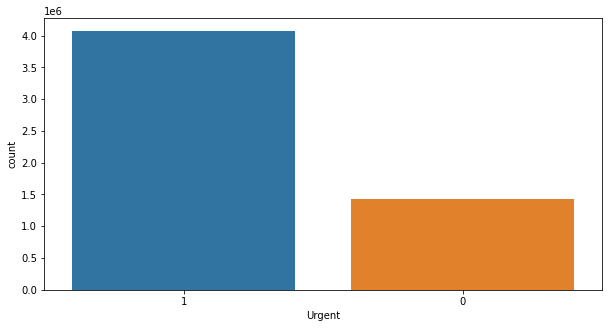

In [37]:
# Plot to see distribution of target classes
plt.figure(figsize = (10, 5))
sns.countplot(x='Urgent', data=big_visual, order=big_visual['Urgent'].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='Primary Type'>

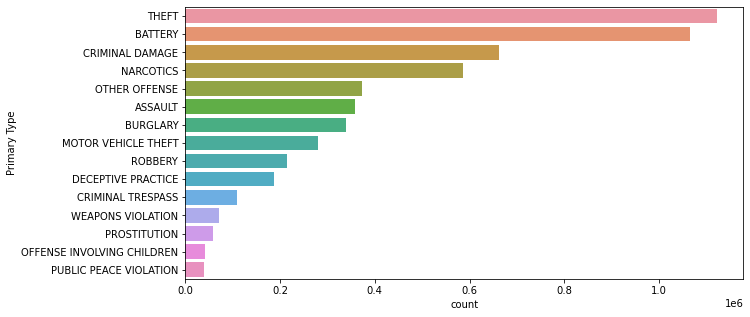

In [38]:
# See if our hypothesis of cutting to only 15 types of crime was correct
plt.figure(figsize = (10, 5))
sns.countplot(y='Primary Type', data=big_visual, order=big_visual['Primary Type'].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='Location Description'>

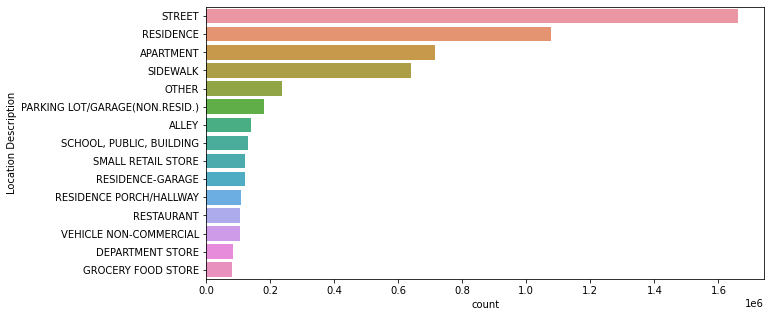

In [39]:
# See if our hypothesis of cutting to only 15 locations was correct
plt.figure(figsize = (10, 5))
sns.countplot(y='Location Description', data=big_visual, order=big_visual['Location Description'].value_counts().index)

<AxesSubplot:xlabel='Weather Condition', ylabel='count'>

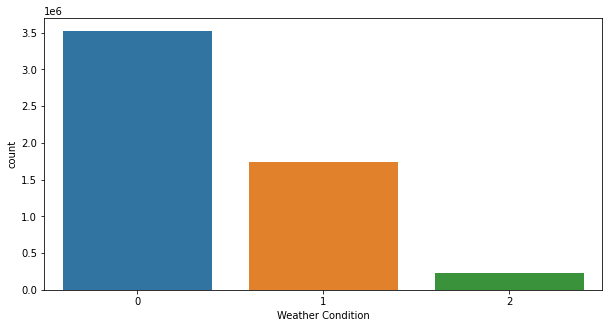

In [40]:
# Visualize the results of our weather data interpretation
plt.figure(figsize = (10, 5))
sns.countplot(x='Weather Condition', data=big_visual, order=big_visual['Weather Condition'].value_counts().index)

**Findings for Task 1:**


It would seem that our created target attribute has a decent distribution of both positive and negative sampels, which should bolster the results of our modeling later. Our assumption that we could cut crime data types and locations after 15 types of each also seems to have been correct, as it is around that threshold that they start to become non-significant. Lastly, the interpretaion of some of the provided weather data has also worked well, as we recieve a number of sample for each, seemingly indicating that the number of crimes greatly drops when there is rain, and then even further when there is snow.

---

**Task 2:** Visualize trends in the occurences of crimes in our data

Text(0, 0.5, 'Number of Crimes')

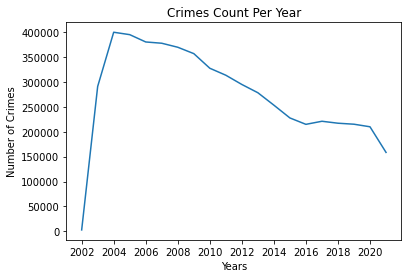

In [41]:
# See trends in crime for each recorded year
big_visual.index = pd.DatetimeIndex(big_visual['Date'])

plt.plot(big_visual.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

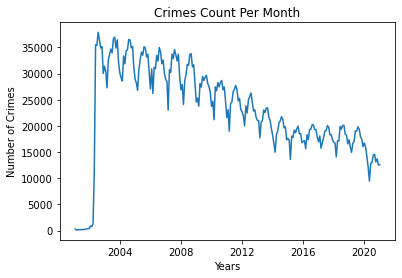

In [42]:
# See trends in crime for each recorded month
plt.plot(big_visual.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

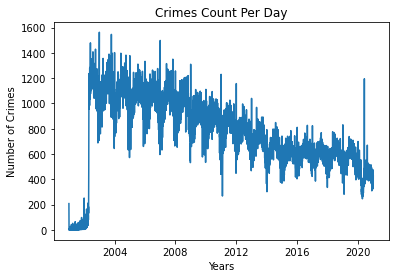

In [43]:
# See trends in crime for each recorded day
plt.plot(big_visual.resample('D').size())
plt.title('Crimes Count Per Day')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

**Findings for Task 2:**


These visualizations seems to show a general trend in crime data, where as we come closer to approaching modern times, the number of crimes decreases significantly. Not only that, but it also reveals that crimes are less likely to happen in winter months. Lastly, they also seem to follow a pattern of oscillating based on day, with less crimes occuring during weekdays. Ideally, our models will be able to pick up on and take these trends into consideration.

---

**Task 3:** Check the results of attempting different principle components

In [30]:
# Reduce to 2 principle components
pca2 = PCA(n_components=2)
X2D = pca2.fit_transform(scale_data)

# Reduce to 5 principle components
pca3 = PCA(n_components=3)
X3D = pca3.fit_transform(scale_data)

# See how one PC for each original column works
pca14 = PCA(n_components=14)
X15D = pca14.fit_transform(scale_data)

In [46]:
print("2 Principle Components:", pca2.explained_variance_ratio_, '\n')
print("3 Principle Components:", pca3.explained_variance_ratio_, '\n')
print("14 Principle Components:", pca14.explained_variance_ratio_)

2 Principle Components: [0.1718307  0.14401298] 

3 Principle Components: [0.1718307  0.14401298 0.1217072 ] 

14 Principle Components: [0.1718307  0.14401298 0.1217072  0.10265651 0.09428777 0.08001935
 0.07163575 0.05932226 0.03875653 0.03181686 0.03047531 0.02087354
 0.01800338 0.01460186]


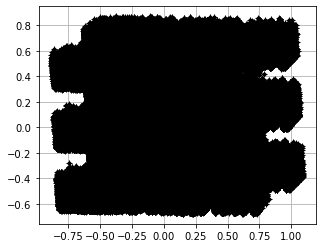

In [47]:
# View the 2D projection
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.grid(True)

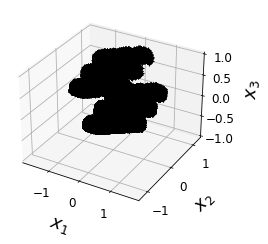

In [52]:
# Plot the 3D dataset, the plane and the projections onto that plane
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

    
ax.plot(X3D[:, 0], X3D[:, 1], X3D[:, 2], "k+")
ax.plot(X3D[:, 0], X3D[:, 1], X3D[:, 2], "k.")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: Matplotlib 3.0.0 has a bug and does not display 3D graphs properly
plt.show()

**Findings for Task 3:**


In this step, the goal was to see if we could reduce the dimensions of the data effectively at all. While it is hard to graph our data past 2D and 3D spaces, we can tell from graphs in those dimensions that lower-dimension principle component analysis will likely not be viable. Looking at the variance ratios of different PCA models as well reveals a similar conclusion, and effectively renders our PCA attempts useless.

---

**Summary of data exploration tasks:**


Overall, the results of some of our data exploration mostly re-affirmed our approaches taken in the pre-processing step. The target attribute should be learnable by different models, and the attributes that we had created from data some of the data interpretation seems valid as well. However, our attempts at dimensionality reduction don't seem to have worked quite as hoped, and will likely have to be discarded.





---

## D. Predictive Modeling

In this step, an attempt is made to train different models on the data that was created. The efficiency and performance of these models are also examined.

**Task 1:** Create and apply a linear regression model to our data

In [53]:
# Create X (predictor) and Y (target)
X = big_data.copy()
X = X.drop(columns=['Urgent'])
y = big_data['Urgent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

# Apply model to the test set
y_pred_test = regr.predict(X_test)

# Evaluate our model's performance
print('Test performance:')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-square = %.4f" % r2_score(y_test, y_pred_test))

Test performance:
Root mean squared error = 0.4344
R-square = 0.0201


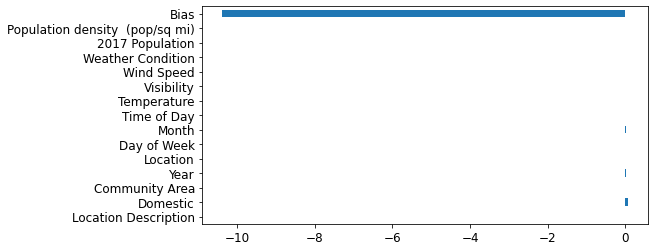

In [54]:
# Display model parameters
params = np.append(regr.coef_, regr.intercept_)
indices = np.append(X.columns.values, 'Bias')
df = pd.DataFrame(params, index=indices)

ax = df.plot(kind='barh', figsize=(8,4))
ax.legend().remove()

**Findings for Task 1:**


Linear regression was the first attempt that came to mind given that we were trying to classify between two discrete classes. The processed data fit decently well into the model, but the score that it returned, along with the weights that it learned for the model were not incredible results.

---

**Task 2:** Create and apply a logistic regression model to our data

**Note:** This task performs very poorly, and is resource heavy. There is no need to run if not required.

In [55]:
# Create a logistic regression model and train it on our split data
log_reg = linear_model.LogisticRegression(solver='lbfgs',random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [56]:
# Observe the resulting coefficients
log_reg.coef_

array([[-2.68604054e-03,  2.07438558e-04,  1.74174039e-03,
         3.11986050e-04, -7.51731705e-04,  4.65445909e-05,
         5.78219491e-04, -1.82006110e-04,  3.95520289e-03,
         9.41409995e-05, -1.14905927e-04, -3.56639726e-06,
        -3.81761644e-06,  2.40256221e-05]])

In [57]:
# Apply model to the test set
y_pred_test = log_reg.predict(X_test)

# Evaluate the models performance
print('Test performance:')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-square = %.4f" % r2_score(y_test, y_pred_test))

Test performance:
Root mean squared error = 0.5103
R-square = -0.3521


Best hyperparameter, regulizer = 0.001
Test F1-score = 0.8503150313322817


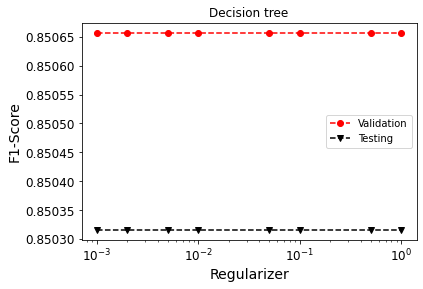

In [58]:
# Attempt different regularization and see how they affect our model
regularizers = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
validationF1 = np.zeros(len(regularizers))
testF1 = np.zeros(len(regularizers))
index = 0
numFolds = 10

np.random.seed(1)
for C in regularizers:
    clf = linear_model.LogisticRegression(C=C, random_state=1, max_iter=200)
    scores = cross_val_score(clf, X_train, y_train, cv=numFolds, scoring='f1')
    validationF1[index] = np.mean(scores)
    
    clf = clf.fit(X_train, y_train)
    Y_predTest = clf.predict(X_test)
    testF1[index] = f1_score(y_test, Y_predTest)
    index += 1

# Plot the results    
plt.plot(regularizers, validationF1, 'ro--', regularizers, testF1, 'kv--')
plt.xlabel('Regularizer')
plt.ylabel('F1-Score')
plt.title('Decision tree')
plt.legend(['Validation','Testing'])
plt.xscale('log')
bestHyperparam = np.argmax(validationF1)
print('Best hyperparameter, regulizer =', regularizers[bestHyperparam])
print('Test F1-score =', testF1[bestHyperparam])

**Findings for Task 2:**

After running some test with logistic regression, it would seem that either I have performed it incorrectly, or that the way I have created my data has made it not-applicable. Regardless, it does not provide anything near the best solution. In an attempt to find different parameters for logistic regression, I tried a similar approach of different regularizing terms, though this became resource heavy, and took a very long time to run. This model ultimately seems like it can be scrapped.

---

**Task 3:** Attempt to apply a clustering approach to our data

In [49]:
# Create potential train and test sets
X_train_clust, X_test_clust = train_test_split(clustering_data, test_size=0.5, random_state=42)

In [29]:
# Try KMeans for clustering first
# 3 Different Models for different numbers of clusters
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans4 = KMeans(n_clusters=4, random_state=42)
kmeans15 = KMeans(n_clusters=15, random_state=42)

In [69]:
y_pred3 = kmeans3.fit_predict(X_train)
y_pred4 = kmeans4.fit_predict(X_train)
y_pred15 = kmeans15.fit_predict(X_train)

In [70]:
# See how many samples are assingned per cluster
def clusterSize(predictions):
    """
    Function to show how many data points fall within each cluster 
    Prints result in format: "{cluster num}: {# of points in cluster}"
    """
    unique, frequency = np.unique(predictions, return_counts = True)
    for clus,samp in enumerate(unique):
        print("{:<2s} : {}".format(str(clus), frequency[samp]))

0  : 51653
1  : 147145
2  : 368412
3  : 135342
4  : 139449
5  : 185578
6  : 135500
7  : 184246
8  : 294308
9  : 280274
10 : 171432
11 : 336975
12 : 137043
13 : 107221
14 : 78253


In [ ]:
# See distributions of different cluster sizes
clusterSize(y_pred3)

In [ ]:
clusterSize(y_pred4)

In [ ]:
clusterSize(y_pred15)

In [71]:
# Compare scores of two halves of the data
print(kmeans15.score(X_train))
print(kmeans15.score(X_test))

-23465435009212.77
-23455887615351.63


In [40]:
# Plot model decision boundaries
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

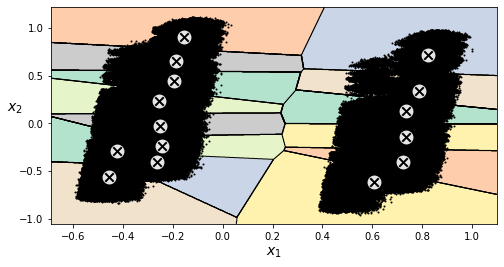

In [41]:
# See how the 2d model works, just for fun
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans15, X2D)
plt.show()

**Findings for Task 3:**

This was the approach which I spent the most time in, as I thought it had the most potential to solve the original problem, given that it is unsupervised learning. The idea was that I would cluster all the data, and crimes with similar labels would end up in the same clusters. Then, when I plotted a new point, if it did not have strong correlation to any of the clusters, it would likely not result in the occurance of a crime. There were a number of challenges to this approach. First, the dimensionality of the data made it difficult, which was originally why I wanted to try PCA. However, as can be seen, PCA did not work the best either. Additionally, it seemed like there wasn't a strong correlation between records with similar crime type labels.

---

**Summary of Predictive Modeling:**

Given that we were trying to classify new records, I wanted to take a number of approached using models that specialized in doing so. As a result, I chose two regression models, linear and logistic. Since these are supervised approaches, I had to rely heavily on the labels that I had created as classifiers from the original data set. Though these worked for the models, I believe that having so many attributes made it difficult for any of my models to accurately create predictions. The last approach that I tried was clustering. In short, this relied on records of similar crime instances getting grouped together, and then if a new record that I was trying to predict had no strong correlation to the cluster it was assigned to, then it was likely not going to be a crime. In other words, if the new data ended up being an outlier when compared to the model that clustering had created, then it would be false. 




---

## E. Conclusions

The goal of this project was to be able to predict crime when given a number of attributes about a location. I took this to mean that we were to analyze the crime records and determine whether or not we should take action on a certain possibility of a crime. This meant that my model inherently operated on the basis that criminals would be discouraged from committing crime in locations that have been heavily persecuted in the past. This changes how our model behaves, but should still allow for it to make accurate predictions. The biggest challenge was determining how to interpret the data that was given, considering that it was only positive records.

Before attempting modeling, it was interesting to see what could be discerned simply from observing the data. First, from some of the visualization, it became obvious that there as a whole, the number of occurences of crime has been declining. Within that, there were also trends were it could be seen that crime was more likely to occur during the summer months, and on the weekends. From some of the data derived from the supplementary files, it could also be seen that crime was significantly less likely to occur when there was precipiation, and even less likely when that precipitation was snow. 

Despite all of the information gained from these records, the modeling approaches that were attempted still struggled. In retrospect, having more attributes may not have been the best approach. Even knowing this, attempts at techniques such as dimensionality reduction did not seem effective. For the modeling itself, Linear Regression seemed to produce the best results. The clustering model was probably the most innovative, but ultimately I was not able to get it to work. Despite this, I was able to make decent progress on it, and think that if explored further, it could yield better results than the regression models.








---